# Interleaved Randomized Benchmarking (IRB)

The interleaved randomized benchmarking routine allows us to estimate the gate fidelity of single
qubit Clifford gates. To demonstrate this routine, consider device noise modelled by an amplitude 
damping channel with decay probability $\gamma=0.01$

In [1]:
import cirq
import numpy as np

decay_prob = 0.05
noise = cirq.AmplitudeDampingChannel(gamma=decay_prob)
simulator = cirq.DensityMatrixSimulator(noise=noise)

We can calculate the average fidelity of this channel [as](https://quantumcomputing.stackexchange.com/questions/16074/how-to-calculate-the-average-fidelity-of-an-amplitude-damping-channel):
$$\begin{align}
\overline{F} &= \int\langle\psi|\mathcal{N_\gamma}(|\psi\rangle\langle\psi|)|\psi\rangle d\psi\\
&=\int\langle\psi|K_0|\psi\rangle\langle\psi|K_0^\dagger|\psi\rangle + \langle\psi|K_1|\psi\rangle\langle\psi|K_1^\dagger|\psi\rangle d\psi\\
& =\frac{1}{4\pi}\int_0^\pi\int_0^{2\pi}\left|\begin{pmatrix}\cos\frac{\theta}{2}&e^{-i\phi}\sin\frac{\theta}{2}\end{pmatrix}\begin{pmatrix}1 & 0 \\0 & \sqrt{1 - \gamma}\end{pmatrix}\begin{pmatrix}\cos\frac{\theta}{2}\\e^{i\phi}\sin\frac{\theta}{2}\end{pmatrix}\right|^2\sin\theta \\
& + \left|\begin{pmatrix}\cos\frac{\theta}{2}&e^{-i\phi}\sin\frac{\theta}{2}\end{pmatrix}\begin{pmatrix}0 & \sqrt{\gamma} \\0 & 0\end{pmatrix}\begin{pmatrix}\cos\frac{\theta}{2}\\e^{i\phi}\sin\frac{\theta}{2}\end{pmatrix}\right|^2\sin\theta d\phi d\theta \\
&=\frac{1}{4\pi}\int_0^\pi\int_0^{2\pi}\left|\cos^2\frac{\theta}{2}+\sqrt{1-\gamma}\sin^2\frac{\theta}{2}\right|^2\sin\theta + \left|\sqrt{\gamma}e^{i\phi}\sin\frac{\theta}{2}\cos\frac{\theta}{2}\right|^2\sin\theta d\phi d\theta \\
&=\frac{1}{2}\int_0^\pi\left(\cos^4\frac{\theta}{2}+(1-\gamma)\sin^4\frac{\theta}{2}+\frac{\sqrt{1-\gamma}}{2}\sin^2\theta + \frac{\gamma}{4}\sin^2\theta\right)\sin\theta d\theta \\
&=\frac{1}{2}\int_0^\pi\sin\theta\cos^4\frac{\theta}{2}+(1-\gamma)\sin\theta\sin^4\frac{\theta}{2}+\frac{\gamma+2\sqrt{1-\gamma}}{4}\sin^3\theta d\theta \\
&=\frac{1}{2}\left(\frac{2}{3} + (1-\gamma)\frac{2}{3} + \frac{\gamma+2\sqrt{1-\gamma}}{4}\frac{4}{3}\right) \\
&=\frac{1}{2}\left(\frac{4}{3} - \frac{\gamma}{3} + \frac{2\sqrt{1-\gamma}}{3}\right) \\
&=\frac{2}{3}-\frac{\gamma}{6} + \frac{\sqrt{1-\gamma}}{3}.
\end{align}$$

Thus we have a gate error $$\frac{1}{3}+\frac{\gamma}{6} - \frac{\sqrt{1-\gamma}}{3}$$

In [2]:
expected_gate_error = 1 / 3 + decay_prob / 6 - np.sqrt(1 - decay_prob) / 3

In [3]:
import supermarq

experiment = supermarq.qcvv.IRB()
experiment.prepare_experiment(100, [1, 5, 10, 15])
experiment.run_with_simulator(simulator=simulator)

Building circuits:   0%|          | 0/400 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/800 [00:00<?, ?it/s]

/home/cdb/miniconda3/envs/client_superstaq/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


IRBResults(target='Local simulator', total_circuits=800, experiment_name='IRB', rb_layer_fidelity=0.967400880362247, rb_layer_fidelity_std=0.0009381203019248942, irb_layer_fidelity=0.9365570504829388, irb_layer_fidelity_std=0.0024157723898343662, average_interleaved_gate_error=0.015941596966377924, average_interleaved_gate_error_std=0.0013339107674075268)


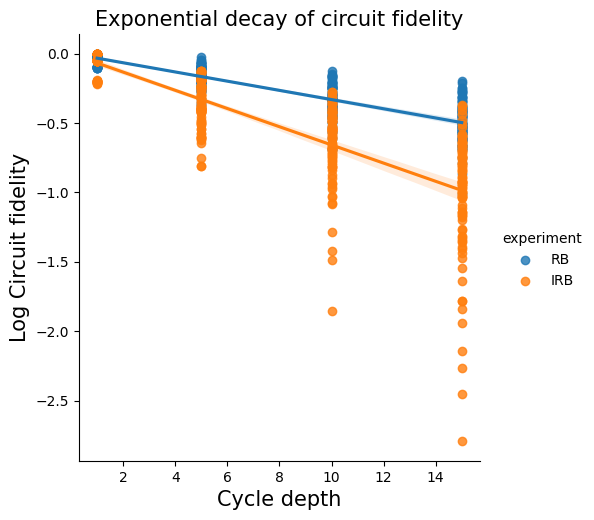

In [4]:
if experiment.collect_data():
    results = experiment.analyze_results(plot_results=True)
    print(results)

In [5]:
print(f"Expected gate error: {expected_gate_error:.6f}")
print(
    f"Measured gate error: {results.average_interleaved_gate_error:.6f} +/- {results.average_interleaved_gate_error_std:.6f}"
)

Expected gate error: 0.016774
Measured gate error: 0.015942 +/- 0.001334
